
# 🧪 Customer Support Classifier — Dataset Exploration (Week 1)

**Goal:** Quick, reproducible exploration of the `customer_support_tickets_clean_500.csv` dataset.

**What you'll do in this notebook:**
1. Load the dataset from `data/`
2. Inspect schema & basic stats
3. Check class distribution
4. Preview random samples per class
5. Look at text length distribution
6. (Optional) Quick train/test split sanity check

> Run this notebook in Google Colab or locally inside the repo.


In [11]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

# Ensure plots show inline
%matplotlib inline


In [12]:

# === Config ===
DATA_PATH = "data/clean/clean_tickets.csv"  # adjust if needed
RANDOM_SEED = 42

# Reproducibility
np.random.seed(RANDOM_SEED)


In [13]:

assert os.path.exists(DATA_PATH), f"Could not find file at {DATA_PATH}. Make sure the CSV is in the data/ folder."
df = pd.read_csv(DATA_PATH)

print("✅ Loaded dataset.")
print("Shape:", df.shape)
df.head()


✅ Loaded dataset.
Shape: (472, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


In [14]:

print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Columns: ['text', 'label', 'ticket_id', 'agent_name']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        472 non-null    object
 1   label       472 non-null    object
 2   ticket_id   472 non-null    int64 
 3   agent_name  472 non-null    object
dtypes: int64(1), object(3)
memory usage: 14.9+ KB
None

Missing values per column:
text          0
label         0
ticket_id     0
agent_name    0
dtype: int64


In [15]:

# Try to normalize expected columns if they exist with different names
# Expected: 'text' and 'label'
candidate_text_cols = [c for c in df.columns if c.lower() in ["text", "ticket_text", "message", "body"]]
candidate_label_cols = [c for c in df.columns if c.lower() in ["label", "category", "class"]]

if candidate_text_cols and "text" not in df.columns:
    df = df.rename(columns={candidate_text_cols[0]: "text"})
if candidate_label_cols and "label" not in df.columns:
    df = df.rename(columns={candidate_label_cols[0]: "label"})

print("Using columns: text ->", "text" in df.columns, ", label ->", "label" in df.columns)
display(df.head(3))


Using columns: text -> True , label -> True


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie


Class distribution:
label
account      115
billing      113
other        125
technical    119
Name: count, dtype: int64


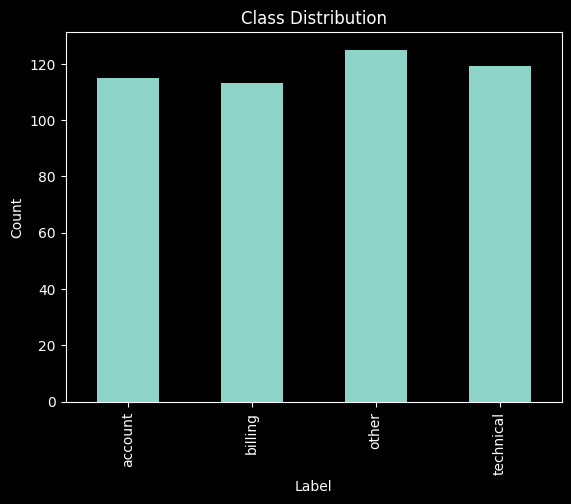

In [16]:

if "label" in df.columns:
    counts = df["label"].value_counts().sort_index()
    print("Class distribution:")
    print(counts)

    # Plot class distribution
    plt.figure()
    counts.plot(kind="bar")
    plt.title("Class Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()
else:
    print("No 'label' column found; please ensure your CSV has a label/category column.")


Text length (words) — summary stats:
count    472.000000
mean       7.381356
std        1.081946
min        5.000000
25%        7.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: text, dtype: float64


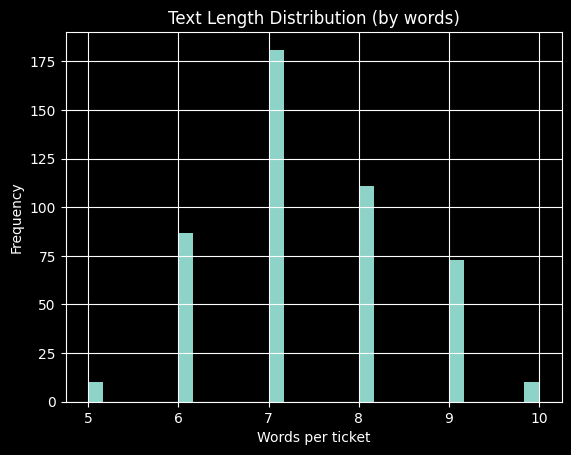

In [17]:

if "text" in df.columns:
    text_lengths = df["text"].astype(str).apply(lambda x: len(x.split()))
    print("Text length (words) — summary stats:")
    print(text_lengths.describe())

    plt.figure()
    text_lengths.hist(bins=30)
    plt.title("Text Length Distribution (by words)")
    plt.xlabel("Words per ticket")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No 'text' column found; please ensure your CSV has a text column.")


In [18]:

if set(["text","label"]).issubset(df.columns):
    def sample_per_class(dataframe, col_label="label", n=3):
        samples = []
        for cls, group in dataframe.groupby(col_label):
            s = group.sample(min(n, len(group)), random_state=RANDOM_SEED)[["text", col_label]]
            s.insert(0, "sample_of", cls)
            samples.append(s)
        return pd.concat(samples, ignore_index=True)

    samples_df = sample_per_class(df, "label", n=3)
    display(samples_df)
else:
    print("Skipping samples per class — missing 'text' or 'label'.")


,sample_of,text,label
0,account,Profile picture upload fails with unknown error.,account
1,account,How do I delete my account and all data?,account
2,account,Profile picture upload fails with unknown error.,account
3,billing,Subscription renewal charged incorrectly this ...,billing
4,billing,Promo code SAVE20 not applied at checkout.,billing
5,billing,Currency converted incorrectly; expected GBP.,billing
6,other,Do you offer discounts for students or NGOs?,other
7,other,Please provide onboarding training for my team.,other
8,other,Requesting invoice to be sent monthly instead ...,other
9,technical,File export to CSV generates corrupted file.,technical


In [19]:

if set(["text","label"]).issubset(df.columns):
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=RANDOM_SEED)
    print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

    # Verify stratification
    print("\nTrain class distribution:")
    print(train_df["label"].value_counts(normalize=True).sort_index())

    print("\nTest class distribution:")
    print(test_df["label"].value_counts(normalize=True).sort_index())
else:
    print("Skipping split — missing 'text' or 'label'.")


Train shape: (377, 4) Test shape: (95, 4)

Train class distribution:
label
account      0.244032
billing      0.238727
other        0.265252
technical    0.251989
Name: proportion, dtype: float64

Test class distribution:
label
account      0.242105
billing      0.242105
other        0.263158
technical    0.252632
Name: proportion, dtype: float64


In [20]:

# Save processed artifacts (optional)
import os
os.makedirs("artifacts", exist_ok=True)
df.head(50).to_csv("artifacts/sample_preview.csv", index=False)
print("Saved artifacts/sample_preview.csv")


Saved artifacts/sample_preview.csv



---

**Notes for interns:**  
- If your CSV uses different column names, adjust the rename cell accordingly.  
- Keep your environment consistent (Python 3.9+).  
- Push your findings as a short markdown summary in the repo (`reports/week1_summary_yourname.md`).

_Last updated: 2025-10-03 15:23 UTC_
